In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print(sns.__version__)
%matplotlib inline

0.8.1


### Gather 3 data sets

In [ ]:
## First dataset: upload twitter_archive_enhanced.csv file. 
df_archv = pd.read_csv("twitter-archive-enhanced.csv")
# df_archv.sample(1)

In [ ]:
## Second dataset: I download the image prediction files pramatically from Udacity server.

import os
import requests

folder_name = 'image_predictions'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
print(response)

with open(os.path.join(folder_name,url.split('/')[-1]), \
          mode='wb') as file:
    file.write(response.content)

In [ ]:
## check the tsv file is downloaded 
df_images = pd.read_csv('image_predictions/image-predictions.tsv',sep='\t')
# df_images.head(1)

In [ ]:
## Thirdly, because I could not connect to twitter, I again download the data directly from the udacity website.

# import os
# import requests

folder_name = 'tweeterdata'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/tweet_json.txt'
response = requests.get(url)
print(response)

with open(os.path.join(folder_name,url.split('/')[-1]), \
          mode='wb') as file:
    file.write(response.content)

In [ ]:
## I open and read the downloaded file; I extracted the key:values I needed and save them in a list. 
import json

tweet_list = [] # list to store result

with open('tweeterdata/tweet_json.txt') as file:  
    for line in file:
        d = json.loads(line) # transform the string back to the dictionary. 
        tweet_list.append({'tweet_id': d['id'],"retweet_count": d["retweet_count"], 'favorite_count': d['favorite_count']})

In [ ]:
df_tweets = pd.DataFrame(tweet_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
#df_tweets.head(1)

## Assess Data

In [ ]:
## Create copies before proceeding.
archives_clean = df_archv.copy()
images_clean = df_images.copy()
tweets_clean = df_tweets.copy()

In [ ]:
archives_clean.info()

In [ ]:
# archv_cleaned.head(10)
images_clean.info()

In [ ]:
tweets_clean.info()

### Quality issues:

#### *Archives* dataset: 
1. This table should not contain retweets. Retweets are duplicates.
2. Erroneous datatypes: 
    1. The columns `in_reply_to_status_id`, `in_reply_to_user_id`, `state_id` and `user_id` are floats.
    2. `timestamp` and `retweeted_status_timestamp` are strings which end in +0000, they should be of type datetime.
3. Many `tweet_id`s do no appear in *images* table and vice versa.
4. Erroneous dog names (`name` column):
    1. some names do not start with Capital letter. They do not look like a name. For example, we have 'a','actually', 'all', 'an', 'by','getting', 'his', 'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite', 'space', 'such', 'the', 'this', 'unacceptable', 'very'.
    2. One dog is named 'O', but it should be "O'Malley".
5. Column `rating_denominator` has values other than 10. Certain `rating_numerator` values are larger than 100, and even reaches 1776. In particular,
    1. Records which contain Floating ratings are interpreted incorrectly.
    2. Certain ratings are not extractely correctly. For example, if date appears in the text, the date may be extracted instead of the rating.
    3. There are unusually large and small ratings. Large ratings usually are due to the fact that many dogs appear together in one picture, so the ratings represent a combination of total ratings of these dogs.
6. Certain records have more than one dog stages.
7. Column `source` contains unnecessary html tags.
8. Certain records in the Column `expanded_urls` contain duplicates.

#### *Images* 
9. In the *images* table, the text format of `p1`, `p2`, `p3` columns is messy.
    1. Underscores are used, which should be replaced by spaces. 
    2. some are lowercase, some are uppercase

#### *Tweet API* does not seem to have quality issues. 

### Tidiness issues.
1. The table *archives* should not contain retweets. Thus, after removing retweets, the columns related to retweets are emtpy and should be removed.
    - The columns `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` should be dropped.
2. In the *Tweet_archive* table, the columns `doggo`, `floofer`, `pupper` and `puppo` can be succinctly represented with one categorical variable.
3. In the *Tweet_archive* table, the `tweet_url` should be extracted from the `text` column.
4. The Tweet API table could be merged with the other two tables.

### Clean

#### Problem: on retweets. Quality issue, 1st problem of archives dataset.

In [ ]:
## there are retweets.
archives_clean[archives_clean.retweeted_status_id.notnull()].shape

#### Define
- Keep the rows which are original tweets and which are not retweets in *archives* table. So we remove the records of which the value of `retweeted_status_id` column is null.

#### Code

In [ ]:
archives_clean = archives_clean[archives_clean.retweeted_status_id.isnull()]

#### Test

In [ ]:
archives_clean[archives_clean.retweeted_status_id.notnull()].shape[0]

#### Problem: Tidiness issue, 1st problem

In [ ]:
archives_clean.info()

#### Define
- remove the columns `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` which are empty.

#### Code

In [ ]:
archives_clean = \
archives_clean.drop(labels = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'],
                   axis = 1)

#### Test

In [ ]:
archives_clean.info()

#### Problem: on erroneous data types. Quality issue, 2nd problem of archives dataset.

In [ ]:
archives_clean.info()

#### Define
- Convert the `in_reply_to_status_id`, `in_reply_to_user_id`, `state_id and user_id` columns to int type. 
- Convert the `timestamp` column to datatime type.

#### Code

In [ ]:
archives_clean['in_reply_to_user_id'] = archives_clean['in_reply_to_user_id'].fillna(0)
archives_clean['in_reply_to_status_id'] = archives_clean['in_reply_to_status_id'].fillna(0)

#archives_clean['in_reply_to_status_id'] = \
#archives_clean['in_reply_to_status_id'].astype(int)
# archives_clean['in_reply_to_user_id'] = archives_clean['in_reply_to_user_id'].fillna(0)
archives_clean = archives_clean.astype({"in_reply_to_status_id": int, "in_reply_to_user_id": int})

In [ ]:
archives_clean['timestamp'] = pd.to_datetime(archives_clean.timestamp)

#### Test

In [ ]:
archives_clean.info()

#### Problem: On missing observations. Quality issue, 3rd problem of archives dataset.  

In [ ]:
## find the common observations which belong both to the images_clean and archives_clean dataset.
len(set(images_clean.tweet_id).intersection(set(archives_clean.tweet_id)))

#### Define
- Only keep observations which appear in both tables (*archives* and *images*).

#### Code

In [ ]:
archives_clean = archives_clean[archives_clean.tweet_id.isin(images_clean.tweet_id)]

#### Test

In [ ]:
set(images_clean.tweet_id).intersection(set(archives_clean.tweet_id)) == set(archives_clean.tweet_id)

#### Problem: on unusual dog names. Quality issue. 4th problem of archives data.

In [ ]:
## get lowercases in the 'name' column
temp_df = archives_clean[archives_clean.name.str.extract(r'^([a-z0-9_\-]+)$', expand=False).notnull()]
temp_df.name.value_counts()

#### Define 
- These lowercaser letters are not dog names. I notice that some names could be recovered from the `text` column, some could not. If the `text` column does not contain the dog name, the `name` cell will be assigned value 'None'.
- Specifically, I observe that the records containing the key word 'named' all have dog name directly following it. So I will use a simple regular expression to extract dog names.
- I notcie also that the name 'O' is wrong. The true name is "O'Malley".

#### Code

In [ ]:
## Assign 'None' to all lowercase names.
archives_clean.loc[temp_df.index,'name'] = 'None'

In [ ]:
temp_series = {}
temp_series['index'] = temp_df.text.str.extract(r'named\s?(\w+)',expand=False).dropna().index
temp_series['values'] = temp_df.text.str.extract(r'named\s?(\w+)',expand=False).dropna().values
for each in range(len(temp_series['index'])): 
    archives_clean.loc[temp_series['index'][each], 'name'] = temp_series['values'][each]

In [ ]:
print(archives_clean[archives_clean.name == 'O'].text)
archives_clean.loc[775, 'name'] = "O'Malley"
print(archives_clean[archives_clean.name == 'O'].text)

#### Test

In [ ]:
## Test selection by 'named'
for each in range(len(temp_series['index'])): 
    print(archives_clean.loc[temp_series['index'][each], 'name'], '<==', \
         archives_clean.loc[temp_series['index'][each], 'text'])
print(archives_clean[archives_clean.name == "O'Malley"].text)

In [ ]:
archives_clean.name.value_counts()

#### Problem: on unusual values in column `rating_numerator`. Quality issue, 5th problem of archives data.

In [ ]:
print(archives_clean.rating_numerator.value_counts().sort_index(),)

for each in archives_clean[archives_clean.rating_numerator > 14].index:
    print(archives_clean.loc[each,'text'], "\n", each)

#### Define
- There are several problems.
    1. Floating ratings are interpreted incorrectly.
    2. Certain extracted ratings are not correct.
    3. There are unusually large and small ratings.
- My solution.
    1. Use regular expression to spot all the floating ratings, and correct them.
    2. The extracted ratings are not correct, because of the presence of multiple presences of the format "number/number". I will extract this pattern using regular expression and correct them.
    3. I will convert the unusually large ratings to ratings with denominator 10 proportionally. **This step will be accomplished later when I clean the rating_denominator column.**


#### Code (dealing with floating integers.)

In [ ]:
print(archives_clean[archives_clean.text.str.contains(r'(\d+(\.\d+))\/(\d+)')].text.values, \
      archives_clean[archives_clean.text.str.contains(r'(\d+(\.\d+))\/(\d+)')].rating_numerator.values)

temp_series['index'] = archives_clean[archives_clean.text.str.contains(r'(\d+(\.\d+))\/(\d+)')].index
temp_series['values'] = [13, 9, 11 ,11] ## I will replace these values by their integer part.

for each in range(len(temp_series['index'])):
    archives_clean.loc[temp_series['index'][each], 'rating_numerator'] = temp_series['values'][each]

#### Test

In [ ]:
for each in range(len(temp_series['index'])):
    print(archives_clean.loc[temp_series['index'][each], 'rating_numerator'], "==>", \
         archives_clean.loc[temp_series['index'][each], 'text'], "\n")

#### Code (dealing with multiple presence of "number/number" format).

In [ ]:
for each in archives_clean.index:
    # archives_clean.text.str.extractall('(\d+\/\d+)')[0].index.get_level_values(0)
    # archives_clean.text.str.extractall('(\d+\/\d+)')[0].index.levels[0]
    if archives_clean.text.str.extractall('(\d+\/\d+)')[0][each].size >= 2:
         print(archives_clean.text.str.extractall('(\d+\/\d+)')[0][each], \
               archives_clean.loc[each, 'text'], \
               [each, archives_clean.loc[each, 'rating_numerator'], archives_clean.loc[each, 'rating_denominator']], "\n")

In [ ]:
for index, num_value in zip([1068, 1165, 1202, 1662, 2335], 
                                         [14,13,11,10, 9]):
    archives_clean.loc[index,'rating_numerator'] = num_value
    archives_clean.loc[index,'rating_denominator'] = 10

#### Test

In [ ]:
for index in [1068, 1165, 1202, 1662, 2335]:
    print(archives_clean.loc[index,'rating_numerator'],archives_clean.loc[index,'rating_denominator'],\
         "==>", archives_clean.loc[index,'text'], '\n')

#### Code (dealing with unusually large numerators when denominator is 10)

In [ ]:
temp_series['index'] = archives_clean[(archives_clean.rating_numerator > 14) & (archives_clean.rating_denominator == 10)].index

for each in archives_clean[(archives_clean.rating_numerator > 14) & (archives_clean.rating_denominator == 10)].index:
    print(archives_clean.loc[each,'text'],"---------- ratings:",\
          archives_clean.loc[each,'rating_numerator'],\
          archives_clean.loc[each,'rating_denominator'], \
          "-------- index:", each,"\n")

In [ ]:
## I will simple replace the numerator by 14, the highest rating in the data set.

for each in temp_series['index']:
    archives_clean.loc[each,'rating_numerator'] = 14

#### Test

In [ ]:
for each in temp_series['index']:
    print(archives_clean.loc[each,'text'],"---------- ratings:",\
          archives_clean.loc[each,'rating_numerator'],\
          archives_clean.loc[each,'rating_denominator'], \
          "-------- index:", each,"\n")

#### Problem: on unusual values in column `rating_denominator`. Quality issue, 5th problem of Archives data. 

In [ ]:
archives_clean.rating_denominator.value_counts()

In [ ]:
# archives_clean[archives_clean.rating_denominator > 10].index.isin(archives_clean[archives_clean.rating_numerator > 14].index)

temp_series['index'] = archives_clean[(archives_clean.rating_denominator > 10)|(archives_clean.rating_denominator < 10)].index

for each in archives_clean[(archives_clean.rating_denominator > 10)|(archives_clean.rating_denominator < 10)].index:
    print(archives_clean.loc[each,'text'],"---------- ratings:",\
          archives_clean.loc[each,'rating_numerator'],\
          archives_clean.loc[each,'rating_denominator'], \
          "-------- index:", each,"\n")

#### Define
- We have unusually large denominators.Mostly, it is because there were many dogs in the picture. These ratings can all be normalized by making 10 the denominator. If the numerator contains floats, I will only keep the integer part.
- There is one exception. The record indexed 516 has no rating. 24/7 actually represents 7 days, 24 hours. I will replace its numerator by the median, denominator by 10.

#### Code

In [ ]:
for each in archives_clean[(archives_clean.rating_denominator > 10)|(archives_clean.rating_denominator < 10)].index:
    archives_clean.loc[each,'rating_numerator'] = \
    int((archives_clean.loc[each,'rating_numerator']/archives_clean.loc[each,'rating_denominator'])*10)
    archives_clean.loc[each,'rating_denominator'] = 10

In [ ]:
archives_clean.loc[516, 'rating_numerator'] = int(np.median(archives_clean.rating_numerator))

In [ ]:
archives_clean['rating_numerator'] = \
archives_clean['rating_numerator'].astype(int)

#### Test

In [ ]:
for each in temp_series['index']:
    print(archives_clean.loc[each,'text'],"---------- ratings:",\
          archives_clean.loc[each,'rating_numerator'],\
          archives_clean.loc[each,'rating_denominator'], \
          "-------- index:", each,"\n")

#### Problem:  on dog stage. Quality issue, 6th problem of archives data.

In [ ]:
temp_series['index'] = []

for each in archives_clean.index:
    if len(set(archives_clean.loc[each, ['doggo', "floofer", "pupper", "puppo"]]))>2:
        # print(archives_clean.loc[each, ['doggo', "floofer", "pupper", "puppo"]])
        print(archives_clean.loc[each, 'text'], "==>", \
              archives_clean.loc[each, 'doggo'], \
              archives_clean.loc[each, 'floofer'], \
              archives_clean.loc[each, 'pupper'],\
              archives_clean.loc[each, 'puppo'], \
              '\n')
        temp_series['index'].append(each)

#### Define
- I will check each text,and replace the incorrect dog stage by None.
- Some records have two dog stages because of more than 1 dog is present in the picture. 
    - These records are all with 'doggo's and 'pupper's, since pupper and doggo sometimes are used interchangeably according to the dogtionary, I will replace all these records by doggo.

#### Code

In [ ]:
archives_clean.loc[temp_series['index'][0], 'puppo'] = 'None'
archives_clean.loc[temp_series['index'][1], 'floofer'] = 'None'
archives_clean.loc[temp_series['index'][2], 'doggo'] = 'None'
archives_clean.loc[temp_series['index'][3], 'pupper'] = 'None'
archives_clean.loc[temp_series['index'][4], 'pupper'] = 'None'
archives_clean.loc[temp_series['index'][5], 'doggo'] = 'None'
archives_clean.loc[temp_series['index'][6], 'pupper'] = 'None'
archives_clean.loc[temp_series['index'][7], 'pupper'] = 'None'
archives_clean.loc[temp_series['index'][8], 'pupper'] = 'None'
archives_clean.loc[temp_series['index'][9], 'pupper'] = 'None'
archives_clean.loc[temp_series['index'][10], 'pupper'] = 'None'

In [ ]:
# temp_df = archives_clean.copy()
archives_clean['dog_stage'] = \
archives_clean[archives_clean.columns[-4:]].apply(lambda x: ','.join(x),axis = 1)
archives_clean["dog_stage"]= \
archives_clean["dog_stage"].str.replace("None", '').str.replace(',','')
# temp_df['dog_stage'].sample(100)
archives_clean['dog_stage'] = \
np.where(archives_clean['dog_stage'] == "", 'None',archives_clean['dog_stage'])
archives_clean[archives_clean.columns[-5:]].sample(1)

#### Test

In [ ]:
for each in temp_series['index']:
    print(archives_clean.loc[each, 'text'], "==>", \
              archives_clean.loc[each, 'doggo'], \
              archives_clean.loc[each, 'floofer'], \
              archives_clean.loc[each, 'pupper'],\
              archives_clean.loc[each, 'puppo'], \
              '\n')

In [ ]:
## If my implementation is incorrect, an error message will be thrown.
for each in archives_clean.index:
    if archives_clean.loc[each, 'dog_stage'] != "None" :
        if archives_clean.loc[each, archives_clean.loc[each, 'dog_stage']] != \
        archives_clean.loc[each, 'dog_stage']:
            print("error", )

#### Problem: on the `source` column. Quality issue. 7th problem of archives.

In [ ]:
archives_clean.source.value_counts()

#### Define
- There are only three possible values for the `source` column.
- We will remove the http tags.

#### Code

In [ ]:
# temp_df = archives_clean.copy()
archives_clean['source'] = archives_clean.source.str.replace(r'<(a\b[^>]*>|/a>)', '')

#### Test

In [ ]:
archives_clean.source.value_counts()

#### Problem: on the `expanded_urls` column. Quality issues, 8th problem of archives data.

In [ ]:
## There are 481 records which contain duplicated urls.
temp_num = 0
for each in archives_clean.loc[archives_clean.expanded_urls.str.contains(",")==True, "expanded_urls"].str.split(","):
    if ((len(each)>1)&(len(set(each)) == 1)):
        temp_num += 1
    #if ((len(each)>1)&(each[0] != each[1])):
    #    print(each)
print(temp_num)

In [ ]:
## The following are some examples.
for each in archives_clean.loc[archives_clean.expanded_urls.str.contains(",")==True, "expanded_urls"].str.split(","):
    if ((len(each)>1)&(each[0] != each[1])):
        print(each)

#### Define
- I will remove the duplicates in `expanded_urls` column.

#### Code

In [ ]:
# temp_df = archives_clean.copy()
temp_series['values'] = archives_clean.expanded_urls.str.contains(",")==True
#archives_clean['expanded_urls'] = \
#archives_clean.loc[archives_clean.expanded_urls.str.contains(",")==True,"expanded_urls"].str.split(",").apply(lambda x: ",".join(list(set(x))))
archives_clean.loc[temp_series['values'],'expanded_urls'] = \
archives_clean.loc[temp_series['values'],"expanded_urls"].str.split(",").apply(lambda x: ",".join(list(set(x))))

In [ ]:
#for each in range(20):
#    print(temp_df.expanded_urls.iloc[each],)

#### Test

In [ ]:
temp_num = 0
for each in archives_clean.loc[archives_clean.expanded_urls.str.contains(",")==True, "expanded_urls"].str.split(","):
    if (len(each) != len(set(each))):
        temp_num += 1
print(temp_num)

#### Problem: on prediction `p1`, `p2`, `p3` text format. Quality issue, 9th problem. Images data.

In [ ]:
# [741, 861, 906]
images_clean.loc[[741, 861, 906],['p1', 'p2', 'p3']]
# images_clean.loc[:,['p1', 'p2', 'p3']].sample(10)

#### Define
- I replace the underscores "_" by empty space.
- I capitalize each word.

#### Code

In [ ]:
# images_clean['p1'] = images_clean.p1.str.replace("_", " ")
# images_clean['p2'] = images_clean.p2.str.replace("_", " ")
# images_clean['p3'] = images_clean.p2.str.replace("_", " ")
# set(list(temp_df.loc[temp_df.p3_dog != True,'p3'].apply(lambda x: ','.join(x.lower().replace("_", ' ').split(" ")))))

for col in ['p1', 'p2', 'p3']:
    
    temp_series['values'] = \
    images_clean.loc[:,col].apply(lambda x: ','.join(x.lower().replace("_", ' ').split(" ")))
    
    for each in images_clean.index:
        l = temp_series['values'].iloc[each].split(",")
        for i in range(len(l)):
            l[i] = l[i].capitalize()
        images_clean.loc[each, col] = " ".join(l)

#### Test

In [ ]:
# images_clean.loc[np.random.choice(images_clean.shape[0], 5), ['p1', 'p2', 'p3']]
images_clean.loc[:, ['p1', 'p2', 'p3']].sample(10)

#### Probelm: on dog stage. Tidiness. 2nd problem.

In [ ]:
archives_clean.sample(1)

#### Define
- Above, I have created the column `dog_stage`. Now I simply remove the 4 redunant columns which represent dog stages.

#### Code

In [ ]:
archives_clean.drop(labels = list(archives_clean.columns[-5:-1]), axis = 1, inplace= True)

#### Test

In [ ]:
# print(archives_clean.sample(1))
print(archives_clean.dog_stage.value_counts())

#### Problem: on extracting url from `text` column. Tidiness. 3rd problem

In [ ]:
for each in archives_clean.sample(5).index:
    print(archives_clean.loc[each,"text"], "\n")

#### Define
- I will extract the http urls, and form a new column called `tweet_urls` to store them.

#### Code

In [ ]:
# temp_df = archives_clean.copy()
# temp_df.text.str.extract(r"((?:https?|ftp):\/\/?[\w/\-?=%.]+\.[\w/\-?=%.]+)")
# print(temp_df.text.iloc[0])
# print(temp_df.text.str.extract(r"((?:https?|ftp):\/\/?[\w/\-?=%.]+\.[\w/\-?=%.]+)").iloc[0])

archives_clean['tweet_urls'] = archives_clean.text.str.extract(r"((?:https?|ftp):\/\/?[\w/\-?=%.]+\.[\w/\-?=%.]+)")
archives_clean['text'] = archives_clean.text.str.replace(r"((?:https?|ftp):\/\/?[\w/\-?=%.]+\.[\w/\-?=%.]+)", "")

#### Test

In [ ]:
# for each in temp_df.sample(5).index:
#     print(temp_df.loc[each,"text"], "----", temp_df.loc[each,"tweet_urls"], "\n")
for each in archives_clean.sample(5).index:
    print("---TEXT： ", archives_clean.loc[each,"text"], "---URLS: ", \
          archives_clean.loc[each,"tweet_urls"], "\n")

#### Problem: On merging. Tidiness, 5th problem.

#### Define
- I will merge the three data sets.

#### Code

In [ ]:
master_clean = pd.merge(archives_clean,images_clean,on='tweet_id')
master_clean = pd.merge(master_clean,tweets_clean,on='tweet_id')

#### Test

In [ ]:
master_clean.info()

#### Store data as csv file

In [ ]:
master_clean.to_csv('twitter_archive_master.csv', encoding='utf-8',index=False)

### Please conduct brief EDA's and come up with some essential graphs.

In [3]:
df = pd.read_csv("twitter_archive_master.csv")

In [4]:
df['timestamp'] = pd.to_datetime(df.timestamp)
df.sample(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
1832,668960084974809088,0,0,2015-11-24 01:11:27,Twitter for iPhone,Meet Jaycob. He got scared of the vacuum. Hide...,https://twitter.com/dog_rates/status/668960084...,10,10,Jaycob,...,0.226309,False,Chesapeake Bay Retriever,0.165878,True,Bathtub,0.056726,False,263,753


In [5]:
### Define a function for calculating outliers.
def is_outliers(x):
    q1 = x.quantile(q = 0.25, interpolation = 'nearest')
    q3 = x.quantile(q = 0.75, interpolation = 'nearest')
    iqr = q3 - q1
    sel = (x < q1 - 1.5 * iqr) | (x > q3 + 1.5 * iqr)
    result = {"values": x[sel], "index": sel}
    return result

# print(is_outliers(df.favorite_count)['values'].sample(10))
# print(df.favorite_count.quantile(0.75, interpolation = 'nearest'))
# df.favorite_count.describe()

### Univariate analysis

####  Number of Tweets over time.

Observation: The number of tweets per day is decreasing constantly. Now it keeps at a rate of 2 ~ 4 tweets per day.

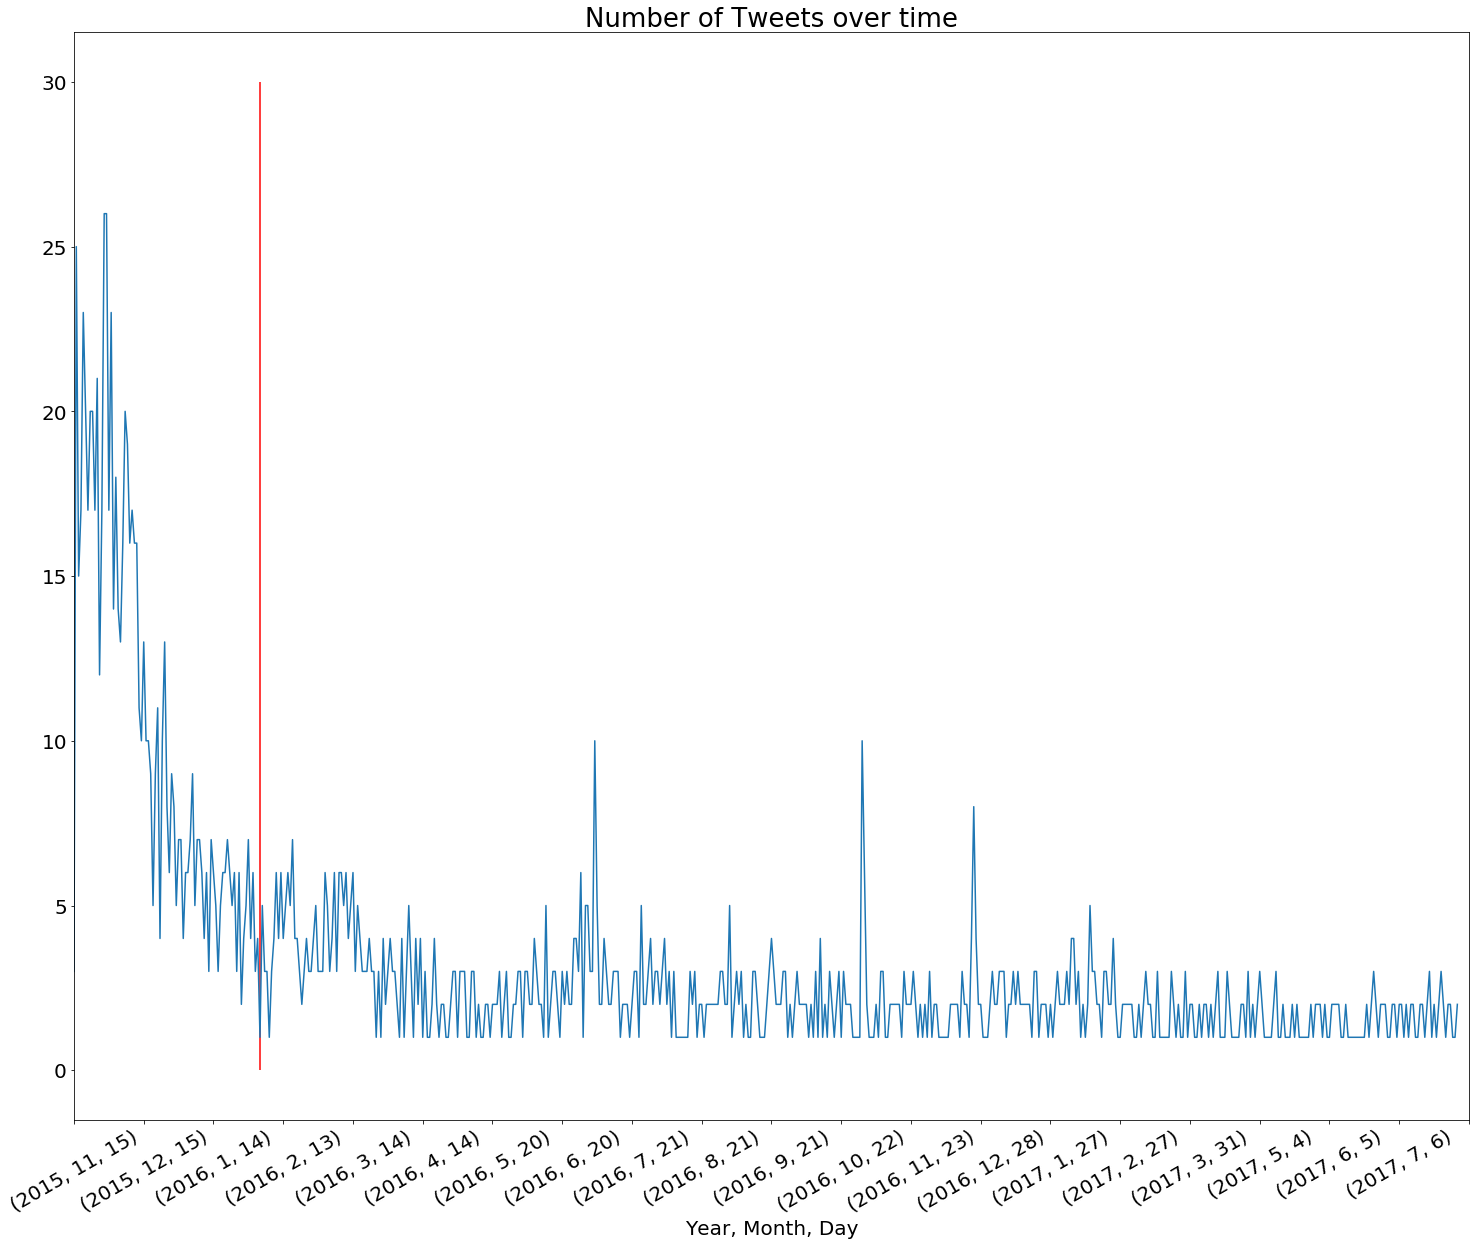

In [6]:
fig, axs = plt.subplots()
df.tweet_id.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month, df["timestamp"].dt.day] )\
.count().plot(kind = 'line',\
              figsize = (25,20), fontsize = 20, ax = axs, xticks= np.arange(0,630,30), rot = 30)
# axs.set_xticks(np.arange(0,600,10))
# print(axs.get_xticks())
axs.set_title(label = 'Number of Tweets over time', fontdict={'fontsize': 26, 'fontweight': 'medium',})
axs.set_xlabel(xlabel = 'Year, Month, Day', fontdict={'fontsize': 20, 'fontweight': 'medium',})
axs.vlines(x = 80, ymin = 0, ymax = 30, \
            colors='red', linestyles='solid', label='')


#### Retweets and Favorites Count

Observation: With less frequent tweets, we would expect that the favoriate count and retweets count to decrease. It is actually not quite the case.

For retweets count, as could be noticed from the scatter plot and the mean-count-per-day plot, we have a steady increasing trend. 

For favorite count, we notice from plots that the variable variation increases, but the gravity (the majority of points) still represents a clear increasing trend.

**As a summary**, Given that the number of tweets decreases to 1 or 2 per day, the number of retweets and favorites manage to keep an increasing trend. This is a sign of popularity, 

In [ ]:
# import statsmodels
# statsmodels.tsa.stattools.adfuller(x = temp_df.retweet_count, regression = 'ct', regresults = True, store = True)

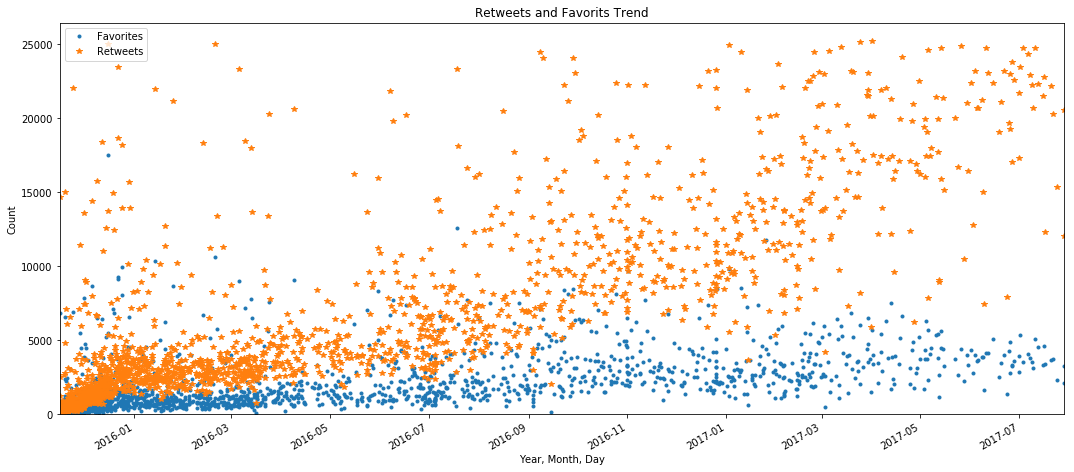

In [7]:
fig, ax = plt.subplots(sharex=True)

temp_df = df[~is_outliers(df.favorite_count)["index"]]

temp_df.plot(x = 'timestamp', y = 'retweet_count', ax=ax, \
             figsize = (18,8), kind = 'line', style = '.')
temp_df.plot(x = 'timestamp', y = 'favorite_count', ax=ax, \
             figsize = (18,8), kind = 'line', style = '*').set_ylim(0,)
#temp_df.favorite_count.groupby([temp_df["timestamp"].dt.year, temp_df["timestamp"].dt.month, \
#                          temp_df["timestamp"].dt.day]).sum()\
#.plot(kind = 'line', ax=axs).set_ylim(0, )

#axs.hlines(y=60000., xmin = np.min(axs.get_xticks()), xmax = np.max(axs.get_xticks()))
plt.title('Retweets and Favorits Trend')
plt.ylabel('Count')
plt.xlabel('Year, Month, Day')
plt.legend(('Favorites', 'Retweets'))

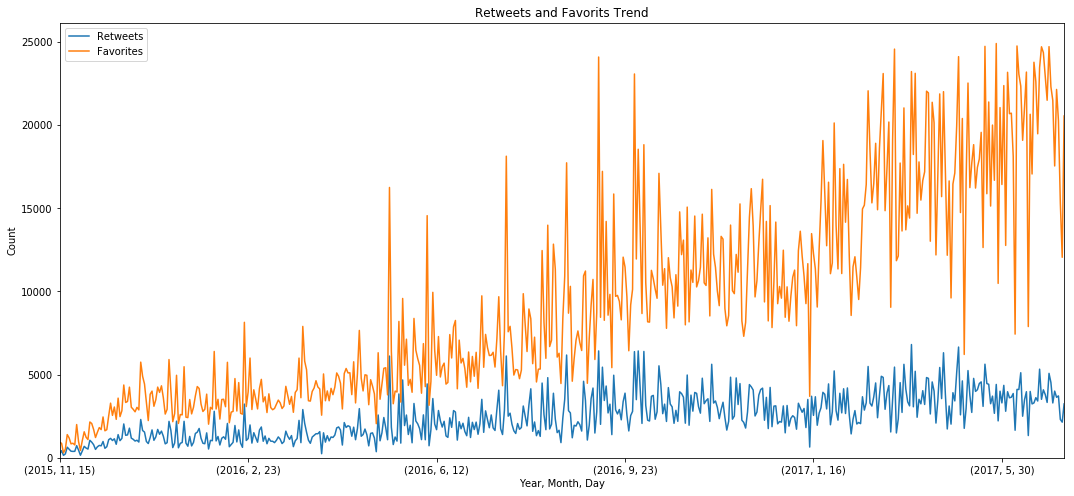

In [8]:
fig, axs = plt.subplots(sharex=True)

#plt.subplots(1, sharex=True)

# temp_df = pd.DataFrame(df.retweet_count.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).mean())

temp_df = df[(~is_outliers(df.favorite_count)["index"]) & (~is_outliers(df.retweet_count)["index"])]

temp_df.retweet_count.groupby([temp_df["timestamp"].dt.year, temp_df["timestamp"].dt.month, \
                         temp_df["timestamp"].dt.day]).mean()\
.plot(kind = 'line', ax=axs, figsize = (18,8))
temp_df.favorite_count.groupby([temp_df["timestamp"].dt.year, temp_df["timestamp"].dt.month, \
                          temp_df["timestamp"].dt.day]).mean()\
.plot(kind = 'line', ax=axs).set_ylim(0, )

axs.hlines(y=60000., xmin = np.min(axs.get_xticks()), xmax = np.max(axs.get_xticks()))
plt.title('Retweets and Favorits Trend')
plt.ylabel('Count')
plt.xlabel('Year, Month, Day')
plt.legend(('Retweets', 'Favorites'))

#### Distribution of dog stage

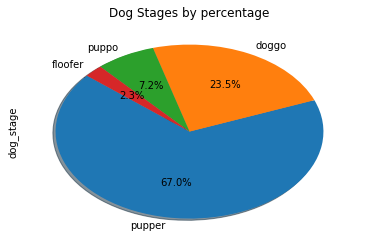

In [9]:
df[df.dog_stage!='None'].dog_stage.value_counts()\
.plot.pie(title="Dog Stages by percentage",autopct='%1.1f%%', shadow=True, startangle=140)

#### Distribution of source

In [ ]:
df.source.value_counts()

#### Dog names using word cloud

In [10]:
df[df.name!="None"].name.value_counts()[df[df.name!="None"].name.value_counts()>=7]# .plot(kind='barh')

Charlie    11
Cooper     10
Oliver     10
Lucy       10
Tucker      9
Penny       9
Sadie       8
Winston     8
Daisy       7
Lola        7
Toby        7
Name: name, dtype: int64

** It appears that there are more male dogs than female dogs. 
- Charlie, Copper are names for male. I consider Oliver as name for males, since it is not among The Best Female Dog Names of 2018: https://www.rover.com/blog/top-female-dog-names/.

In [11]:
print("Fraction of male dog names among the most popular names (sample of 100): \nCharlie, Oliver, Cooper, Tucker, Winston, Toby: \n")
(11+10+10+9+8+7)/df[df.name!="None"].name.value_counts()[df[df.name!="None"].name.value_counts()>=7].sum()

Fraction of male dog names among the most popular names (sample of 100): 
Charlie, Oliver, Cooper, Tucker, Winston, Toby: 



0.57291666666666663

In [12]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

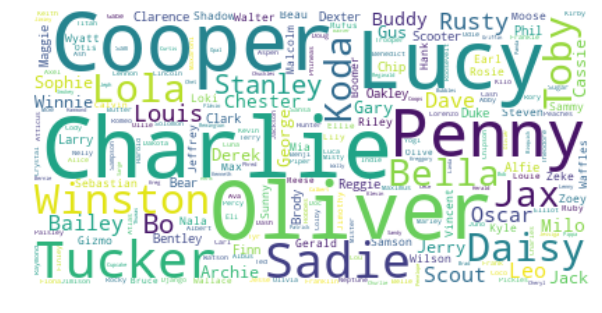

In [13]:
temp_text = " ".join(name for name in df[df.name!='None'].name)
wordcloud = WordCloud(max_font_size=60, max_words=300, background_color="white").generate(temp_text)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
# https://www.datacamp.com/community/tutorials/wordcloud-python

#### Ratings Numerators 

Text(0.5,1,'Distribution of ratings')

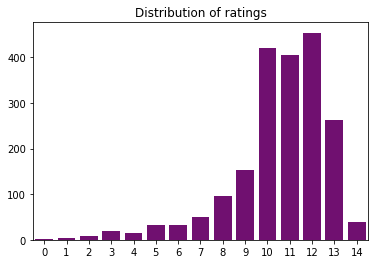

In [14]:
fig, axes = plt.subplots()
temp_df=df.rating_numerator.value_counts()
sns.barplot(x=temp_df.index, y = temp_df.values, color='purple', ax = axes)
axes.set_title("Distribution of ratings")
# plt.savefig("Distribution of rating numerators.png")

#### Two variables: Rating and Retweet&Favorite count

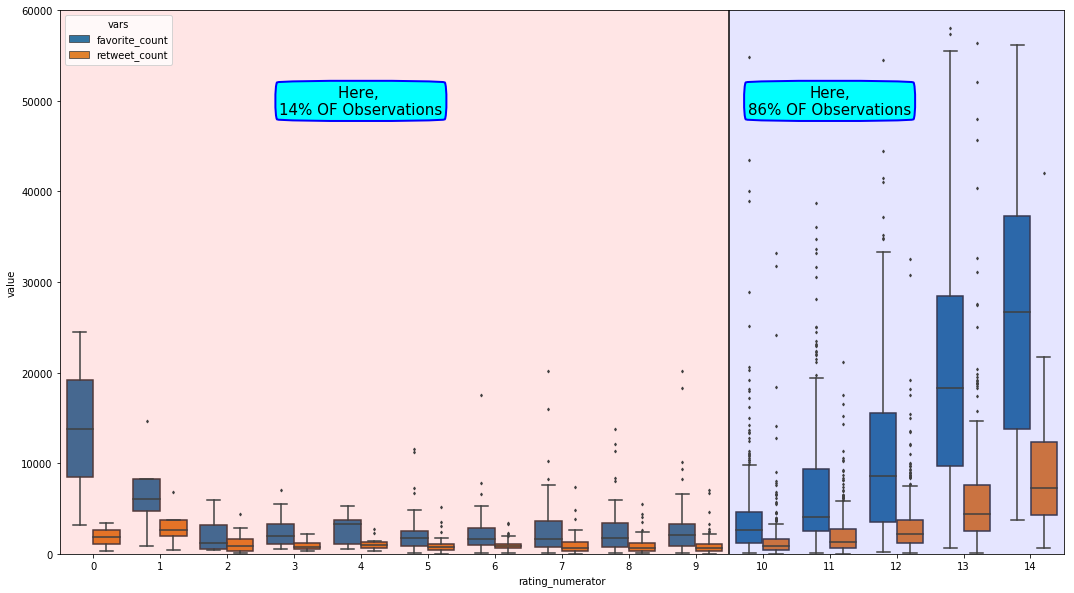

In [15]:
fig, axes = plt.subplots(figsize = (18,10))

# sns.regplot(x=df['rating_numerator'], y=df["favorite_count"], fit_reg=False,scatter_kws={'alpha':0.3}, x_jitter=True)
# df.favorite_count.groupby(df['rating_numerator']).plot(kind = 'box')
temp_df=pd.melt(df,id_vars=['rating_numerator'],value_vars=['favorite_count','retweet_count'],var_name='vars')
# sns.boxplot(y='rating_numerator',x='value',data=temp_df,hue='vars',orient='h')
sns.boxplot(x='rating_numerator',y='value',data=temp_df,hue='vars',orient='v', fliersize= 2)
axes.set_ylim(0,60000)
axes.axvspan(xmin=9.5, xmax = 15, ymin=0, ymax = 60000, facecolor = 'b',alpha = 0.1)
axes.axvspan(xmin=-1, xmax = 9.5, ymin=0, ymax = 60000, facecolor = 'r',alpha = 0.1)
## axs.get_xticks()


axes.text(x=11, y=50000, s= "Here,\n86% OF Observations",ha="center", va="center", rotation=0,
            size=15,
            bbox=dict(boxstyle="Round4,pad=0.3", fc="cyan", ec="b", lw=2))

axes.text(x=4, y=50000, s= "Here, \n14% OF Observations",ha="center", va="center", rotation=0,
            size=15,
            bbox=dict(boxstyle="Round4,pad=0.3", fc="cyan", ec="b", lw=2))

axes.vlines(x=9.5, ymin=0,ymax=60000)

#### References

In [ ]:
# https://stackoverflow.com/questions/9957637/how-can-i-set-the-background-color-on-specific-areas-of-a-pyplot-figure
# https://matplotlib.org/users/annotations.html
# https://stackoverflow.com/questions/13583153/how-to-zoomed-a-portion-of-image-and-insert-in-the-same-plot-in-matplotlib